# Homework 16.5
# Caelan Osman
# March 15, 2022

## Exercise 16.19

In [2]:
import os
import time
import warnings
import numpy as np
import cvxpy as cp
from imageio import imread
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
warnings.filterwarnings('ignore')

## Exercise 16.19

Assume that $\alpha > 0$ and that $\lambda \in [0, 1]$, and that $\|\cdot \|$ is a convex norm. Let $W$ be fixed and let $X$ be a design matrix. We show that 

\begin{align}
\operatorname{minimize}_{H}\quad  &\|X - WH\| + \alpha[\lambda (\|W\|_{L^1} + \|H \|) +(1 - \lambda)(\|W\|_F + \|H\|_F)]\\
&H\succeq 0 
\end{align}

Is a convex optimization of $H$. First off, notice that $H \succeq 0$ is the same as $-H_{11} \leq 0, \ldots, - H_{rd} \leq 0$. 
Each of those inequalities is affine thus convex. 
Therefore our inequality constraint is a convex constraint. 
Furthermore recall that a linear combination of convex functions is convex and a composition an affine function with a convex function is convex.
Note that $WH$ is an affine function and recall that $\| \cdot \|$ is a convex norm.
Therefore

\begin{align} 
\|X - WH\|
\end{align}

Is convex. 
Further, the remaining pieces of the objective function are convex because $\|\cdot \|_{L^1}$ and $\|\cdot \|_F$ are both convex norms. 
Thus

\begin{align}
\|X - WH\| + \alpha[\lambda (\|W\|_{L^1} + \|H \|) +(1 - \lambda)(\|W\|_F + \|H\|_F)]\\
\end{align}

Is a linear combination of convex functions. 
Thus convex.
Therefore the problem is convex.
The proof that if $H$ is fixed and $W$ then the resulting objective function being convex is the exact same.

## Exercise 16.20

Linear combination of convex is convex
A composition of a convex and affine function is convex. 

In [5]:
class NMFRecommender:

    def __init__(self, random_state=15, rank=3, maxiter=200, tol=1e-3):
        """The parameter values for the algorithm"""

        # this is for random initializations
        self.random_state = random_state
        # the rank to project to
        self.rank = rank
        # max iterations to find the optimizer
        self.maxiter = maxiter
        # tolerance to quit the iterations
        self.tol = tol
    
    def initialize_matrices(self, m, n):
        """randomly initialize the W and H matrices,"""
        # checks that rank is small enough
        assert self.rank < np.min([m, n])
        np.random.seed(self.random_state)
        self.W = np.random.random((m, self.rank))
        self.H = np.random.random((self.rank, n))
      
    def fit(self, V):
        """Fits W and H weight matrices using CVXPY"""

        # initialize our random matrices
        self.initialize_matrices(V.shape[0], V.shape[1])

        
        # check for NaNs and change to zeros
        where_nan = np.isnan(V)
        V[where_nan] = 0
        M = np.ones_like(V)
        M[where_nan] = 0

        # create variables with values
        W = cp.Variable(self.W.shape, nonneg=True)
        H = cp.Variable(self.H.shape, nonneg=True)
        W.value = self.W
        H.value = self.H

        # iterate at most maxiter times to solve the problem
        # switching off which problem to solve
        for _ in range(self.maxiter):

            # solve for W using H value
            objective = cp.Minimize(cp.norm(cp.multiply(M, V -  W@H.value), 'fro'))
            problem = cp.Problem(objective)
            result = problem.solve()
            # fix NaN problem

            # solve for H using W value
            objective = cp.Minimize(cp.norm(cp.multiply(M, V - W.value@H), 'fro'))
            problem = cp.Problem(objective)
            result = problem.solve()
            # fix NaN problem
            # check convergence
            if np.linalg.norm(V - W.value @ H.value, ord='fro') < self.tol:
                break

        self.W = W.value
        self.H = H.value
        return result

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        return self.W@self.H

## Exercise 16.21

In [3]:
def problem16_21():

    # generate nonnegative X
    X = np.random.uniform(low=0, high=10.1, size=(10, 5))


    #######################
    # Part 1
    #######################
    r_vals = [1, 2, 3, 4]

    my_time = dict()
    my_accuarcy = dict()
    sklearn_time = dict()
    sklearn_accuracy = dict()
    for r in r_vals:
        start = time.time()
        nmf = NMFRecommender(rank=r)
        nmf.fit(X)
        end = time.time()
        my_time[r] = end - start
        my_accuarcy[r] = np.linalg.norm(X - nmf.W @ nmf.H, ord='fro' )

        start = time.time()
        model = NMF(n_components=r)
        W = model.fit_transform(X)
        end = time.time()
        sklearn_time[r] = end - start
        H = model.components_
        sklearn_accuracy[r] = np.linalg.norm(X - W@H, ord='fro')


    for r in r_vals:
        print('Rank: ' + str(r))
        print()
        print('My time: ' + str(my_time[r]))
        print('My accuracy: ' + str(my_accuarcy[r]))
        print()
        print('Sklearn time: ' + str(sklearn_time[r]))
        print('Sklearn Accuracy: ' + str(sklearn_accuracy[r]))
        print()

    return

problem16_21()

Rank: 1

My time: 2.4527480602264404
My accuracy: 17.02180648954411

Sklearn time: 0.05254006385803223
Sklearn Accuracy: 17.02180648954367

Rank: 2

My time: 2.2151401042938232
My accuracy: 11.858954312305928

Sklearn time: 0.002782106399536133
Sklearn Accuracy: 11.858954370695566

Rank: 3

My time: 2.34079909324646
My accuracy: 6.629271255597835

Sklearn time: 0.001997709274291992
Sklearn Accuracy: 6.629271585358981

Rank: 4

My time: 2.337360382080078
My accuracy: 4.24289405104591

Sklearn time: 0.0051271915435791016
Sklearn Accuracy: 4.242901563982447



As we can see from the above calculations my implementation is nearly as good as scikit learn in terms of accuracy but their code runs much faster.

## Problem 16.22

The code above has been modified up above in the fit function where the \textbf{np.isnan} function is.

In [6]:
def problem16_22():
    # generate nonnegative X
    # flatten it for easier random index change
    X = np.random.uniform(low=0, high=10.1, size=(10, 5)).flatten()
    indices = np.random.choice(np.arange(X.size), replace=False, size=3)
    # change 3 indices to nan and reshape
    X[indices] = np.nan
    X = X.reshape((10, 5))
    W = X.copy()
    W[np.isnan(X)] = 0

    # now perform NMF

    accuracy = dict()
    speed = dict()
    for r in [1, 2, 3, 4]:
        start = time.time()
        nmf =NMFRecommender(rank=r)
        nmf.fit(X)
        end = time.time()
        speed[r] = end - start 
        # check accuracy
        accuracy[r] = np.linalg.norm(W - nmf.W@nmf.H, ord='fro')

    for r in [1, 2, 3, 4]:
        print('Rank: ' + str(r))
        print()
        print('Time: ' + str(speed[r]))
        print('Accuracy: ' + str(accuracy[r]))
        print()
    
    return

problem16_22()

Rank: 1

Time: 2.5207936763763428
Accuracy: 15.569812742265249

Rank: 2

Time: 2.6288743019104004
Accuracy: 12.108951007868951

Rank: 3

Time: 2.5284557342529297
Accuracy: 8.784480299082112

Rank: 4

Time: 2.6011619567871094
Accuracy: 4.3769542553718965



## Exercise 16.23

lambda = 0, alpha = 0
k = 5


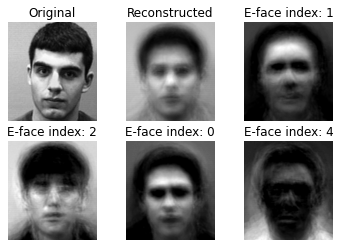

k = 19


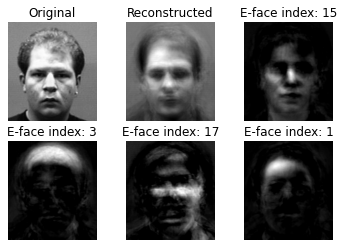

k = 75


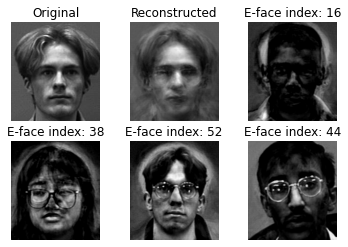

In [5]:
#get data
def get_faces(path="../NMF_Recommender/faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.array(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image, (m,n))
    #show image
    plt.imshow(image, cmap = "gray")
    
    if plt_show:
        plt.show()
        
    return

def problem16_23():

    faces = get_faces()

    k_vals = [5, 19, 75]
    print('lambda = 0, alpha = 0')
    for k in k_vals:
        print('k = ' + str(k))
        model = NMF(n_components=k)
        W = model.fit_transform(faces)
        H = model.components_
        random_e_face_index = np.random.choice(np.arange(k), replace=False, size=4)
        random_eigen_faces = H[random_e_face_index] 
        random_image = np.random.randint(low=0, high=153)

        plt.subplot(2, 3, 1)
        show(faces[random_image])
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        show((W@H)[random_image])
        plt.title('Reconstructed')
        plt.axis('off')

        count = 3
        for j, e_face in enumerate(random_eigen_faces):
            plt.subplot(2, 3, count)
            show(e_face)
            plt.title('E-face index: ' + str(random_e_face_index[j]))
            plt.axis('off')
            count += 1

        plt.show()

    return

problem16_23()

Now we preform the same analysis but with regularization parameters enabled. 

lambda = 0.5, alpha = 1e-05
k = 5


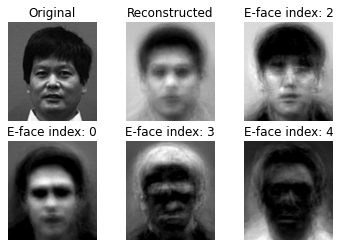

k = 19


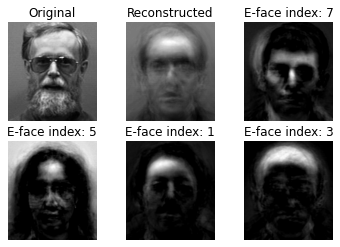

k = 75


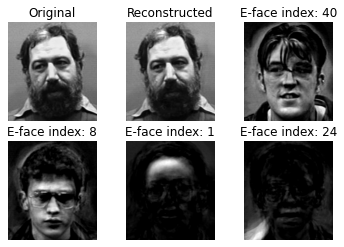

lambda = 0.5, alpha = 10
k = 5


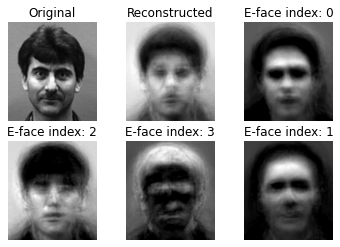

k = 19


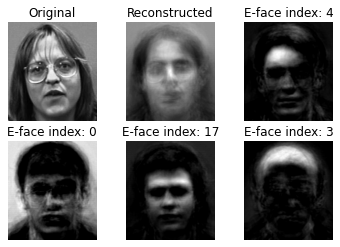

k = 75


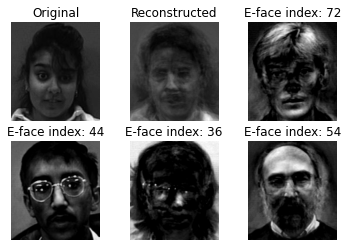

lambda = 0.5, alpha = 1000
k = 5


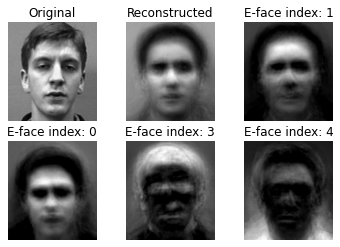

k = 19


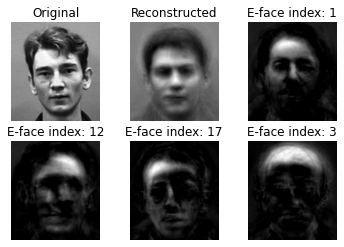

k = 75


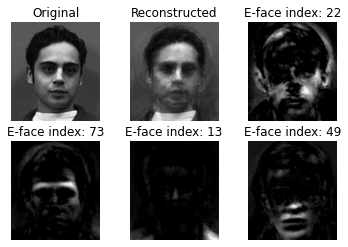

lambda = 1, alpha = 1e-05
k = 5


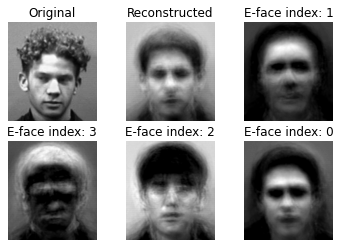

k = 19


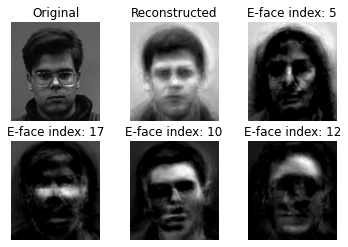

k = 75


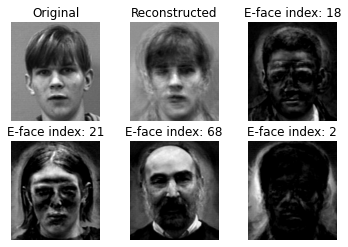

lambda = 1, alpha = 10
k = 5


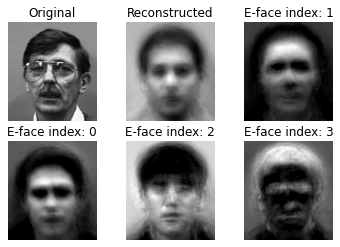

k = 19


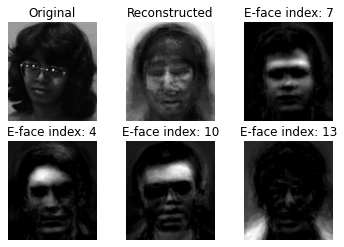

k = 75


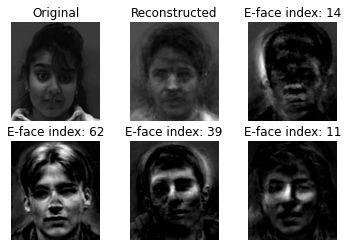

lambda = 1, alpha = 1000
k = 5


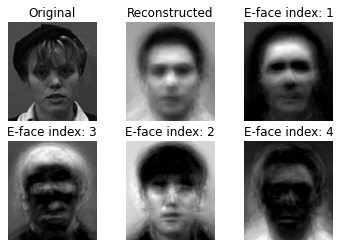

k = 19


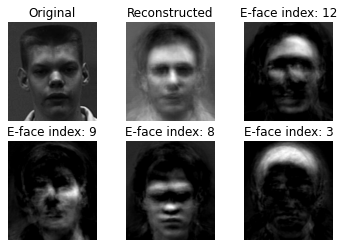

k = 75


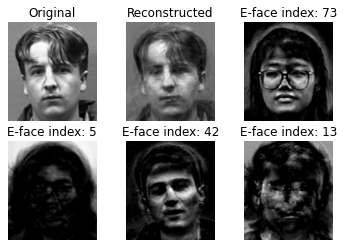

In [6]:
def problem16_23_2(): 

    faces = get_faces()
    k_vals = [5, 19, 75]
    for lam in [0.5, 1]:
        for alpha in [10**(-5), 10, 10**3]:
            print('lambda = ' + str(lam) + ', alpha = ' + str(alpha))
            for k in k_vals:
                print('k = ' + str(k))
                model = NMF(n_components=k, l1_ratio=lam, alpha=alpha)
                W = model.fit_transform(faces)
                H = model.components_
                random_e_face_index = np.random.choice(np.arange(k), replace=False, size=4)
                random_eigen_faces = H[random_e_face_index] 
                random_image = np.random.randint(low=0, high=153)

                plt.subplot(2, 3, 1)
                show(faces[random_image])
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, 3, 2)
                show((W@H)[random_image])
                plt.title('Reconstructed')
                plt.axis('off')

                count = 3
                for j, e_face in enumerate(random_eigen_faces):
                    plt.subplot(2, 3, count)
                    show(e_face)
                    plt.title('E-face index: ' + str(random_e_face_index[j]))
                    plt.axis('off')
                    count += 1

                plt.show()

    return
problem16_23_2()